In [1]:
import os
import numpy as np
import pandas as pd
import pickle
import quandl
from datetime import datetime

In [7]:
# Pull pricing data for 3 more BTC exchanges
exchanges = ['COINBASE','BITSTAMP','ITBIT']

exchange_data = {}

exchange_data['KRAKEN'] = btc_usd_price_kraken

for exchange in exchanges:
    exchange_code = 'BCHARTS/{}USD'.format(exchange)
    btc_exchange_df = get_quandl_data(exchange_code)
    exchange_data[exchange] = btc_exchange_df

Loaded BCHARTS/COINBASEUSD from cache
Loaded BCHARTS/BITSTAMPUSD from cache
Loaded BCHARTS/ITBITUSD from cache


In [8]:
def merge_dfs_on_column(dataframes, labels, col):
    '''Merge a single column of each dataframe into a new combined dataframe'''
    series_dict = {}
    for index in range(len(dataframes)):
        series_dict[labels[index]] = dataframes[index][col]
        
    return pd.DataFrame(series_dict)

In [9]:
# Merge the BTC price dataseries' into a single dataframe
btc_usd_datasets = merge_dfs_on_column(list(exchange_data.values()), list(exchange_data.keys()), 'Weighted Price')

In [10]:
btc_usd_datasets.tail()

,BITSTAMP,COINBASE,ITBIT,KRAKEN
Date,,,,
2018-04-23,8890.297806,8896.090864,8898.437612,8911.565955
2018-04-24,9320.970539,9333.950293,9296.388911,9340.380489
2018-04-25,9178.499797,9179.481005,9218.070073,9191.712953
2018-04-26,8881.373724,8905.532970,8890.942698,8881.221549
2018-04-27,9212.069204,9193.746159,9248.551669,9198.796507


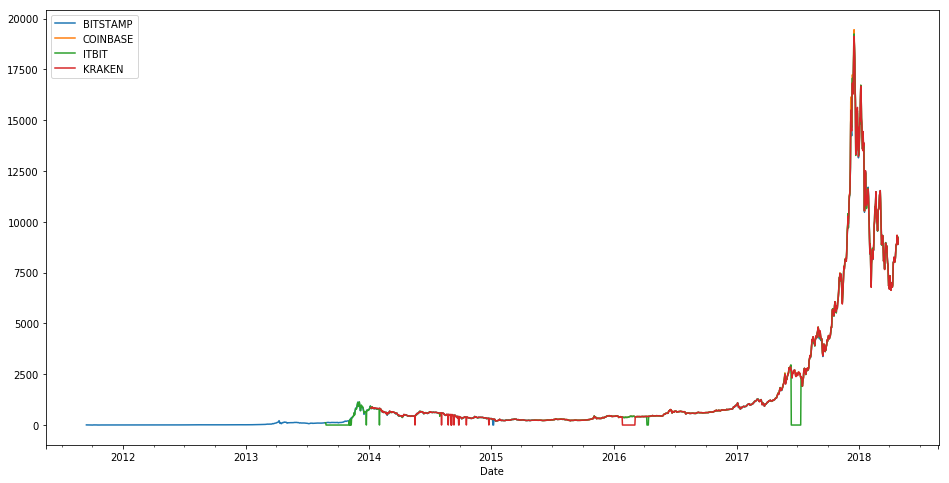

In [11]:
# Plot all of the BTC exchange prices
btc_usd_datasets.plot(figsize=(16,8))
plt.show()


In [12]:
# Remove "0" values
btc_usd_datasets.replace(0, np.nan, inplace=True)

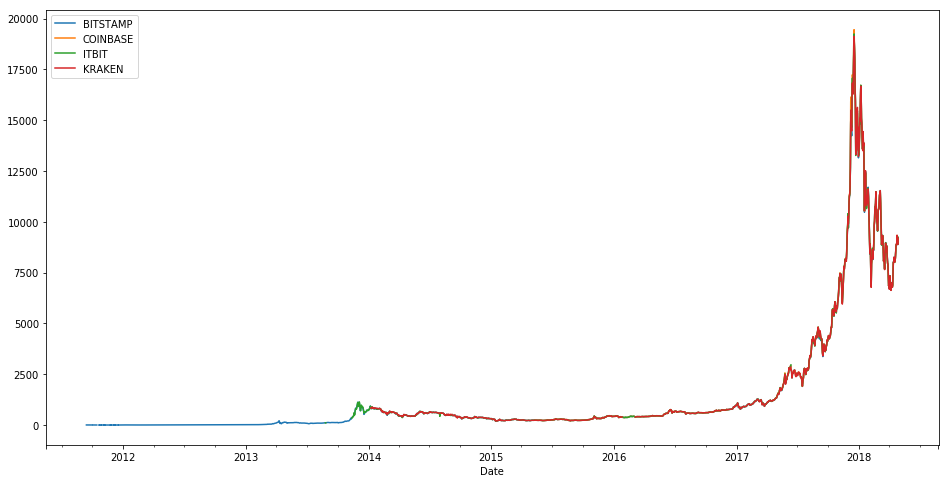

In [13]:
btc_usd_datasets.plot(figsize=(16,8))
plt.show()

In [14]:
# Calculate the average BTC price as a new column
btc_usd_datasets['avg_btc_price_usd'] = btc_usd_datasets.mean(axis=1)

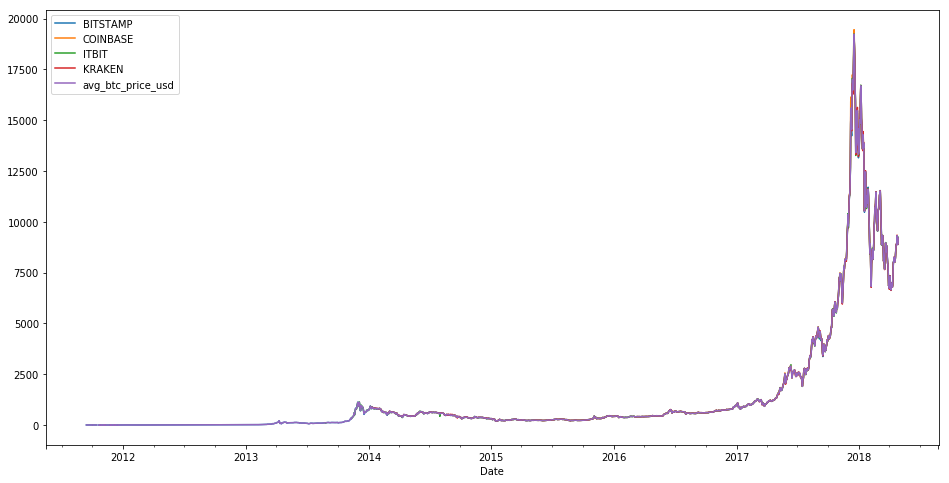

In [15]:
# Plot the average BTC price
btc_usd_datasets.plot(figsize=(16,8))
plt.show()

In [16]:
def get_json_data(json_url, cache_path):
    '''Download and cache JSON data, return as a dataframe.'''
    try:        
        f = open(cache_path, 'rb')
        df = pickle.load(f)   
        print('Loaded {} from cache'.format(json_url))
    except (OSError, IOError) as e:
        print('Downloading {}'.format(json_url))
        df = pd.read_json(json_url)
        df.to_pickle(cache_path)
        print('Cached {} at {}'.format(json_url, cache_path))
    return df

In [17]:
base_polo_url = 'https://poloniex.com/public?command=returnChartData&currencyPair={}&start={}&end={}&period={}'
start_date = datetime.strptime('2015-01-01', '%Y-%m-%d') # get data from the start of 2015
end_date = datetime.now() # up until today
pediod = 86400 # pull daily data (86,400 seconds per day)

def get_crypto_data(poloniex_pair):
    '''Retrieve cryptocurrency data from poloniex'''
    json_url = base_polo_url.format(poloniex_pair, start_date.timestamp(), end_date.timestamp(), pediod)
    data_df = get_json_data(json_url, poloniex_pair)
    data_df = data_df.set_index('date')
    return data_df

In [18]:
altcoins = ['ETH','LTC','XRP','ETC','STR','DASH','SC','XMR','XEM']

altcoin_data = {}
for altcoin in altcoins:
    coinpair = 'BTC_{}'.format(altcoin)
    crypto_price_df = get_crypto_data(coinpair)
    altcoin_data[altcoin] = crypto_price_df

Loaded https://poloniex.com/public?command=returnChartData&currencyPair=BTC_ETH&start=1420088400.0&end=1524999782.885193&period=86400 from cache
Loaded https://poloniex.com/public?command=returnChartData&currencyPair=BTC_LTC&start=1420088400.0&end=1524999782.885193&period=86400 from cache
Loaded https://poloniex.com/public?command=returnChartData&currencyPair=BTC_XRP&start=1420088400.0&end=1524999782.885193&period=86400 from cache
Loaded https://poloniex.com/public?command=returnChartData&currencyPair=BTC_ETC&start=1420088400.0&end=1524999782.885193&period=86400 from cache
Loaded https://poloniex.com/public?command=returnChartData&currencyPair=BTC_STR&start=1420088400.0&end=1524999782.885193&period=86400 from cache
Loaded https://poloniex.com/public?command=returnChartData&currencyPair=BTC_DASH&start=1420088400.0&end=1524999782.885193&period=86400 from cache
Loaded https://poloniex.com/public?command=returnChartData&currencyPair=BTC_SC&start=1420088400.0&end=1524999782.885193&period=86

In [19]:
altcoin_data['ETH'].tail()

,close,high,low,open,quoteVolume,volume,weightedAverage
date,,,,,,,
2018-04-24,0.072752,0.075550,0.071800,0.072099,34672.207296,2572.453773,0.074194
2018-04-25,0.069600,0.072995,0.066600,0.072750,37676.936120,2622.182638,0.069596
2018-04-26,0.071486,0.071750,0.067945,0.069600,44267.315458,3100.220866,0.070034
2018-04-27,0.072114,0.073500,0.069847,0.071419,36321.487970,2595.728809,0.071465
2018-04-28,0.073217,0.073778,0.071850,0.072114,10636.865786,776.747493,0.073024


In [20]:
# Calculate USD Price as a new column in each altcoin dataframe
for altcoin in altcoin_data.keys():
    altcoin_data[altcoin]['price_usd'] =  altcoin_data[altcoin]['weightedAverage'] * btc_usd_datasets['avg_btc_price_usd']

In [21]:
# Merge USD price of each altcoin into single dataframe 
combined_df = merge_dfs_on_column(list(altcoin_data.values()), list(altcoin_data.keys()), 'price_usd')

In [22]:
# Add BTC price to the dataframe
combined_df['BTC'] = btc_usd_datasets['avg_btc_price_usd']

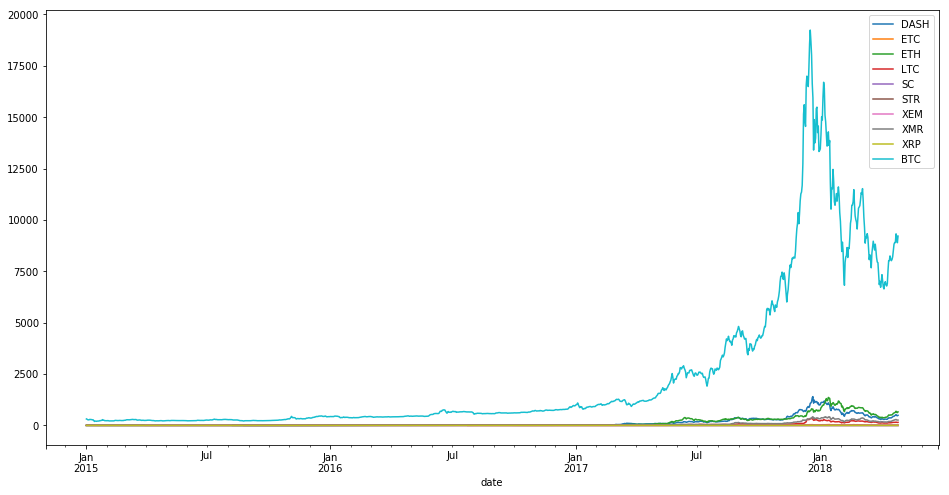

In [23]:
# Chart all of the altocoin prices
combined_df.plot(figsize=(16,8))
plt.show()   ### Scale the plot
#df_scatter(combined_df, 'Cryptocurrency Prices (USD)', seperate_y_axis=False,y_axis_label='Coin Value (USD)', scale='log')

These correlation coefficients are all over the place. Coefficients close to 1 or -1 mean that the series' are strongly correlated or inversely correlated respectively, and coefficients close to zero mean that the values are not correlated, and fluctuate independently of each other.

In [20]:
def extract_bitinfocharts(coin, metric="price", coin_col=False, metric_col=False):

        """Retrieve historical data for a specific cyrptocurrency scraped from bitinfocharts.com

        Parameters

        ----------

        coin : the code of the cryptocurrency (e.g. 'btc' for bitcoin)

            full range of available coins can be found on bitinfocharts.com

        metric : the particular coin information to be retrieved

            (options are limited to those listed on bitinfocharts.com

            including 'price', 'marketcap', 'transactions' and 'sentinusd'

        coin_col : whether to include the coin name as a column

            (default is False i.e. the column is not included)

        metric_col : whether to include the metric name as a column

            (default is False i.e. the column is not included)

            

        Returns

        -------

        pandas Dataframe

        """
        ## hard-coding dates for now
        from_date = "2017-04-27"
        to_date = "2018-04-27"
        
        if coin not in ['btc', 'eth', 'xrp', 'bch', 'ltc', 'dash', 'xmr', 'btg', 'etc', 'zec', 

                        'doge', 'rdd', 'vtc', 'ppc', 'ftc', 'nmc', 'blk', 'aur', 'nvc', 'qrk', 'nec']:

            raise ValueError("Not a valid coin")

        if metric not in ['transactions', 'size', 'sentbyaddress', 'difficulty', 'hashrate', 'price', 

                          'mining_profitability', 'sentinusd', 'transactionfees', 'median_transaction_fee', 

                        'confirmationtime', 'marketcap', 'transactionvalue', 'mediantransactionvalue',

                         'tweets', 'activeaddresses', 'top100cap']:

            raise ValueError("Not a valid bitinfocharts metric")

        new_col_name = "_".join([coin, metric])
        parsed_page = Request("https://bitinfocharts.com/comparison/{}-{}.html".format(metric, coin),

                            headers = {'User-Agent': 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.11 (KHTML, like Gecko) Chrome/23.0.1271.64 Safari/537.11'})

         
        try: 

            parsed_page = urlopen(parsed_page, timeout=20).read()

            parsed_page = parsed_page.decode("utf8")

        except Exception as e:

            return pd.DataFrame({"error":e}, index=[0])

        start_segment = parsed_page.find("new Dygraph")

        if start_segment != -1:

            start_list = parsed_page.find('[[', start_segment)

            end_list = parsed_page.find(']]', start_list)

            parsed_page = parsed_page[start_list:end_list]

        else:

            return pd.DataFrame({"error":"Could not find the appropriate text tag"}, index=[0])

        parsed_page = parsed_page.replace('new Date(', '')

        parsed_page = parsed_page.replace(')', '')

        parsed_page = parsed_page.replace('null', '0')

        parsed_page = parsed_page.replace('["', '{"date":"')

        parsed_page = parsed_page.replace('",', '","{}":'.format(new_col_name))

        parsed_page = parsed_page.replace('],', '},')

        parsed_page = parsed_page + '}]'

        output = json.loads(parsed_page)

        output = pd.DataFrame(output)

        output['date'] = pd.to_datetime(output['date'], format="%Y-%m-%d")

        output = output[(output['date']>=from_date) & (output['date']<=to_date)]

        # for consistency, put date column first

        output = output[['date', new_col_name]]

        if coin_col:

            output['coin'] = coin

        if metric_col:

            output['metric'] = metric

        return output.sort_values(by='date', ascending=True).reset_index(drop=True)

    

In [21]:

from urllib.request import Request, urlopen
import json
import pandas as pd

all_coins_df = extract_bitinfocharts("btc")


In [23]:
bitinfocoins = ['btc', 'eth', 'xrp', 'bch', 'ltc', 'dash', 'xmr', 'etc', 'zec', 
                        'doge', 'rdd', 'vtc', 'ftc', 'nmc', 'blk', 'aur', 'nvc', 'qrk']

for coin in bitinfocoins[1:]:
    all_coins_df = all_coins_df.merge(extract_bitinfocharts(coin), on="date", how="left")

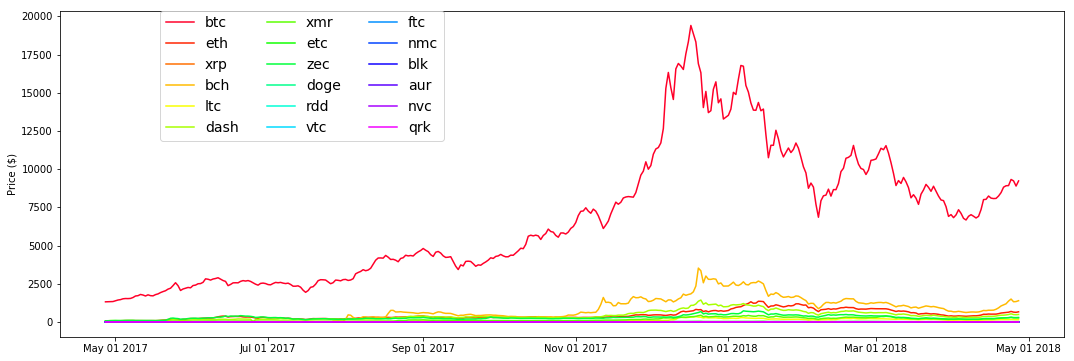

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt
import datetime

fig, ax1 = plt.subplots(1, 1, figsize=(18, 6))

cm = plt.get_cmap('gist_rainbow')

ax1.set_xticks([datetime.date(j,i,1) for i in range(1,13,2) for j in range(2017, 2019)])
ax1.set_xticklabels([datetime.date(j,i,1).strftime('%b %d %Y') for i in range(1,13,2) for j in range(2017, 2019)])
for coin,color in zip(bitinfocoins, [cm(1.*i/len(bitinfocoins)) for i in range(len(bitinfocoins))]):
    ax1.plot(all_coins_df['date'].astype(datetime.datetime), 
             all_coins_df[coin+'_price'], label=coin, color=color)
ax1.legend(bbox_to_anchor=(0.1, 1), loc=2, borderaxespad=0., ncol=3, prop={'size': 14})
ax1.set_ylabel('Price ($)')
plt.show()

This graph just compare the price for single units of each coin. More relevant here is the relative change in price since the start of 2017, which we can plot (pct_change)using pandas.

In [26]:
# replace all columns (except date) with percentage change
all_coins_df.iloc[:,1:] = all_coins_df.iloc[:,1:].divide(all_coins_df.iloc[-5:,1:].mean(), axis=1)

C:\Users\mohan\Anaconda3\lib\site-packages\matplotlib\scale.py:111: RuntimeWarning: invalid value encountered in less_equal
  out[a <= 0] = -1000


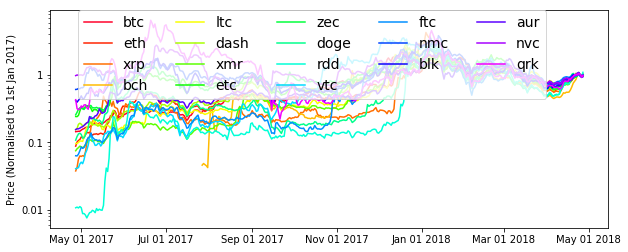

In [28]:
from matplotlib.ticker import ScalarFormatter
import matplotlib.ticker as ticker
import numpy as np

fig, ax1 = plt.subplots(1, 1, figsize=(10, 4))

cm = plt.get_cmap('gist_rainbow')

ax1.set_xticks([datetime.date(j,i,1) for i in range(1,13,2) for j in range(2017, 2019)])
ax1.set_xticklabels([datetime.date(j,i,1).strftime('%b %d %Y') for i in range(1,13,2) for j in range(2017, 2019)])
for coin,color in zip(bitinfocoins, [cm(1.*i/len(bitinfocoins)) for i in range(len(bitinfocoins))]):
    ax1.plot(all_coins_df['date'].astype(datetime.datetime), 
             all_coins_df[coin+'_price'].replace(to_replace=0, method='ffill'), 
             label=coin, color=color)
ax1.set_yscale('log')
# via https://stackoverflow.com/questions/21920233/matplotlib-log-scale-tick-label-number-formatting
ax1.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y,pos: (
            '{{:.{:1d}f}}'.format(int(np.maximum(-np.log10(y),0)))).format(y)))
ax1.legend(bbox_to_anchor=(0.05, 1), loc=2, borderaxespad=0., ncol=5, prop={'size': 14})
ax1.set_ylabel('Price (Normalised to 1st Jan 2017)')
plt.show()

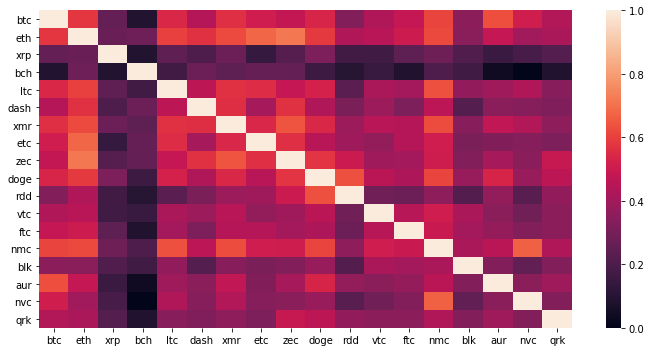

In [30]:
### Pearson Coorelation
import seaborn as sns
import matplotlib.pyplot as plt
corr = all_coins_df.iloc[:,1:].pct_change().corr(method='pearson')
corr = corr.dropna(axis=0, how='all').dropna(axis=1, how='all')
plt.figure(figsize=(10, 5))
sns.heatmap(corr, 
            xticklabels=[col.replace("_price", "") for col in corr.columns.values],
            yticklabels=[col.replace("_price", "") for col in corr.columns.values],
            vmin=0, vmax=1)
plt.tight_layout()
plt.show()

The above graph shows that cryptos are heavily correlated- they tend to spike and crash collectively. Reason being - the vast majority of coins can only be exchanged with the few big coins (e.g. btc and eth). As they are priced relative to these big coins, a change in btc or eth will also change the value of those smaller coins. 